<a href="https://colab.research.google.com/github/mengen-liu/sysid/blob/main/RobotArm_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [17]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from scipy import signal

np.random.seed(41)
tf.compat.v1.set_random_seed(68)

Import dataset

In [18]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/robot_arm.dat',sep='\t',names=['u','y'],index_col=False)
print(data.shape)

# estimation
ye = data.y.values[0:750]
ue = data.u.values[0:750]
# test
yt = data.y.values[750:]
ut = data.u.values[750:]

deltay = (data.y.max() - data.y.min())/2
y0 = data.y.min() + deltay

deltau = (data.u.max() - data.u.min())/2
u0 = data.u.min() + deltau

(1024, 2)


Define useful functions

In [19]:
def scaler(x,x0,delta):
    return (x-x0)/delta

def rescaler(x,x0,delta):
    return x*delta+x0
    
def matReg(y,u,ny,nu):
    # for debuging code
    # y= np.array([1, 2, 3,4,5,6,7,8,9,10])
    # u= np.array([1, 2, 3,4,5,6,7,8,9,10])

    p = np.max((ny,nu)) + 1
    (N, ) = y.shape
    (Nu, ) = u.shape
    
    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)
    
    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1 
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)
        
        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):] 


Plot data

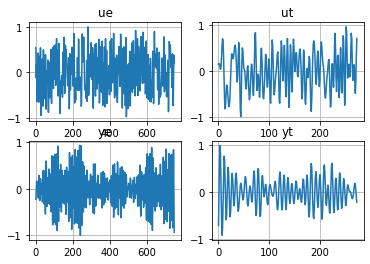

In [20]:
# Data scaling -1,1
ye_n = scaler(ye,y0,deltay)
ue_n = scaler(ue,u0,deltau)

yt_n = scaler(yt,y0,deltay)
ut_n = scaler(ut,u0,deltau)

plt.figure()
plt.subplot(221)
plt.plot(ue_n)
plt.title('ue')
plt.grid()
plt.subplot(222)
plt.plot(ut_n)
plt.title('ut')
plt.grid()
plt.subplot(223)
plt.plot(ye_n)
plt.title('ye')
plt.grid()
plt.subplot(224)
plt.plot(yt_n)
plt.title('yt')
plt.grid()
plt.show()

Create output and regression matrix

In [21]:
ny = 2
nu = 3 # model orders
(Ye_n,Phie) = matReg(ye_n,ue_n,ny,nu)
(Yt_n,Phit) = matReg(yt_n,ut_n,ny,nu)

Define model architecture

In [22]:
_ , ninp = Phie.shape
nout = 1
nneu = 35     # how many neurons per layer
h_layer = 3   # how many hidden layers

# model definition
input_ = keras.layers.Input(shape=(ninp,))
hidden = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal",)(input_)
h = 1
while h<h_layer:
    h += 1
    hidden = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden)

output = keras.layers.Dense(nout)(hidden)
# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])
# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)
# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

Finally train the model

In [23]:
batch_size = 1
last_loss = 1
while (last_loss >= 1e-3 and batch_size<=128):
    batch_size = batch_size*2 
    history = model.fit(Phie, Ye_n, epochs=5, batch_size = batch_size)
    last_loss = history.history['loss'][-1]

print('-------------- Batch size / Loss --------------')
print(f'Batch size = {batch_size}')
print(f'Loss       = {last_loss}')

Epoch 1/5
374/374 [==============================] - 1s 1ms/step - loss: 0.0386
Epoch 2/5
374/374 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 3/5
374/374 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 4/5
374/374 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 5/5
374/374 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 1/5
187/187 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 2/5
187/187 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 3/5
187/187 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 4/5
187/187 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 5/5
187/187 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 1/5
94/94 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 2/5
94/94 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 3/5
94/94 [===========================

Run one-step-ahead prediction

In [24]:
# One step ahead
ye_pred1_n = model.predict(Phie)
yt_pred1_n  = model.predict(Phit)

R2test1  = r2_score(Yt_n, yt_pred1_n)
R2train1  = r2_score(Ye_n, ye_pred1_n)

print('-------------- One step ahead  --------------')
print(f'R2test1   =  {R2test1}')
print(f'R2train1  =  {R2train1}')

9/9 [==============================] - 0s 1ms/step
-------------- One step ahead  --------------
R2test1   =  0.9811775222729349
R2train1  =  0.9926310994642871


Run free-run simulation (prediction over prediction)

In [27]:
# Free Run
# ye_pred0_n = freeRun(model,ye_n,ue_n,ny,nu)
yt_pred0_n  = freeRun(model,yt_n,ut_n,ny,nu)

# R2train0 = r2_score(Ye_n, ye_pred0_n)
R2test0  = r2_score(Yt_n, yt_pred0_n)

print('-------------- Free Run  --------------')
print(f'R2test0   =  {R2test0}')
# print(f'R2train0  =  {R2train0}')

1/1 [==============================] - 0s 13ms/step
-------------- Free Run  --------------
R2test0   =  0.7625854914416182


Plot predictions

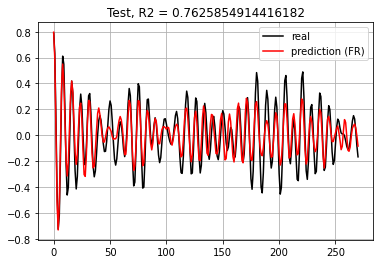

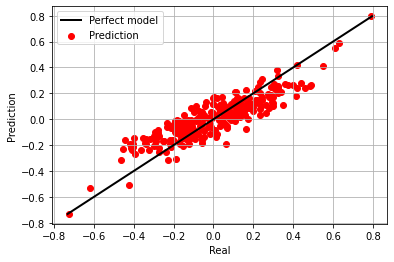

In [32]:
Yt = rescaler(Yt_n,y0,deltay)
yt_pred0 = rescaler(yt_pred0_n,y0,deltay)

plt.figure()
# plt.subplot(211)
# plt.plot(Ye,'k',y_train_pred0,'r')
# plt.title('Estimation')
# plt.legend(('real','prediction (FR)'))
# plt.grid()
# plt.subplot(211)
plt.plot(Yt,'k',yt_pred0,'r')
plt.title(f'Test, R2 = {R2test0}')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt),min(yt_pred0))
maxY = max(max(Yt),max(yt_pred0))
plt.scatter(Yt,yt_pred0,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()